# FIUFIP: Que No Se Escape Nadie

## Introducción

Este trabajo consiste en analizar una serie de datos recoletados por la agencia gubernamental de recaudación de impuestos *FIUFIP*.

Buscaremos entender como se relacionan estos datos y determinar un metodo de si una persona tiene **altos ingresos** o **bajos ingresos** a partir de los datos recibidos, que consisten en una serie de atributos de la persona que la agencia fue llenando y catalogando a la persona como de altos ingresos o no.



## Objetivos

**Tarea**: explicar qué conclusiones se pueden llegar a partir de analizar los datos recolectados

* Saber cómo entender cada uno de los datos
* Saber cómo se relacionan entre sí 
* Saber si se puede sacar alguna conclusión o descubrir un patrón a partir de estos

**Adicionalmente**

* Saber cuáles son los factores más importantes que determinan si un usuario **tiene altos** o **bajos ingresos** {*varible_target*}.

**Baseline**: código simple 

* intente predecir el target (si el usuario tiene **altos ingresos** o **bajos ingresos**).




## Carga de librerias y dataset

In [1]:
from collections import Counter 
import requests 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as px
from matplotlib import pyplot as plt
from pandas_profiling import ProfileReport

from sklearn.feature_extraction import FeatureHasher
from sklearn.feature_selection import VarianceThreshold
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import (
    KBinsDiscretizer,
    LabelEncoder,
    MinMaxScaler,
    Normalizer,
    OneHotEncoder,
    OrdinalEncoder,
    PowerTransformer,
    RobustScaler,
    StandardScaler,
)

Tambien leemos el dataset, que está en formato CSV desde Google Drive.

In [2]:
with requests.get(
    "https://docs.google.com/spreadsheets/d/1-DWTP8uwVS-dZY402-dm0F9ICw_6PNqDGLmH0u8Eqa0/export?format=csv"
) as r, open("fiufip_dataset.csv", "wb") as f:
    for chunk in r.iter_content():
        f.write(chunk)
        


In [3]:
df = pd.read_csv("fiufip_dataset.csv")

# Ser contribuyente y proveer todos los datos a FIUFIP puede volverse complicado ¿Hay datos que falten en el dataset provisto?


Por ser una base de datos de la agencia FIUFIP, es posible que algunos contribuyentes hayan decido no responder o responder erroneamente a la hora de exponer sus datos personales. Esto puede llevar a que haya datos faltantes. Veamos si hay datos faltantes y ya que estamos visualicemos todas las features provistas en el dataset

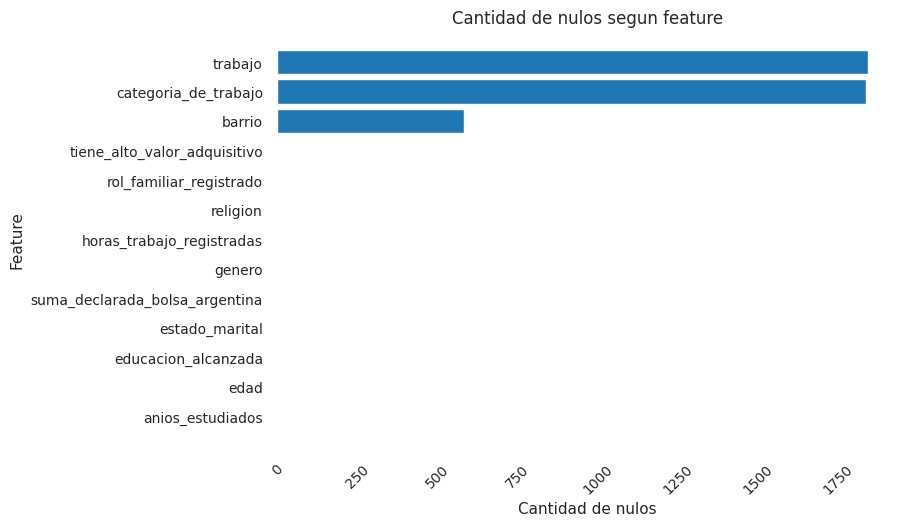

In [4]:
plt.figure(dpi = 100)
df.rename(columns={'ganancia_perdida_declarada_bolsa_argentina':'suma_declarada_bolsa_argentina'},inplace=True)
nulos = df.isnull().sum().sort_values(ascending = True)


y_pos = np.arange(len(nulos.index))
plt.barh(y_pos, nulos.values, align='center')
plt.yticks(y_pos, nulos.index)
plt.ylabel('Feature')
plt.xlabel('Cantidad de nulos')
plt.xticks(rotation = 45)
plt.title('Cantidad de nulos segun feature')
plt.show()

Se pueden observar todas las features provistas. En particular solo tres de ellas presentan valores nulos. Resulta llamativo que los nulos en categoria de trabajo y trabajo sean similiares pero primero veamos sucede con la feature barrio 

## ¿Qué sucede y cómo se distribuye la feature barrio? ¿A qué puede deberse su cantidad de valores nulos?

Veamos la cantidad de posibles opciones de barrio que hay en el dataset

In [5]:
len(df.barrio.value_counts().index)


41

Lo primero a destacar es que hay 41 barrios mientrás que Capital Federal tiene 48, luego los datos faltantes podrían deberse a que no estaban todas las opciones disponibles al momento de obtener los datos. Debido a esto cambiemos el Nan por 'Otro' y veamos la distribución de la feature en cuestión

[]

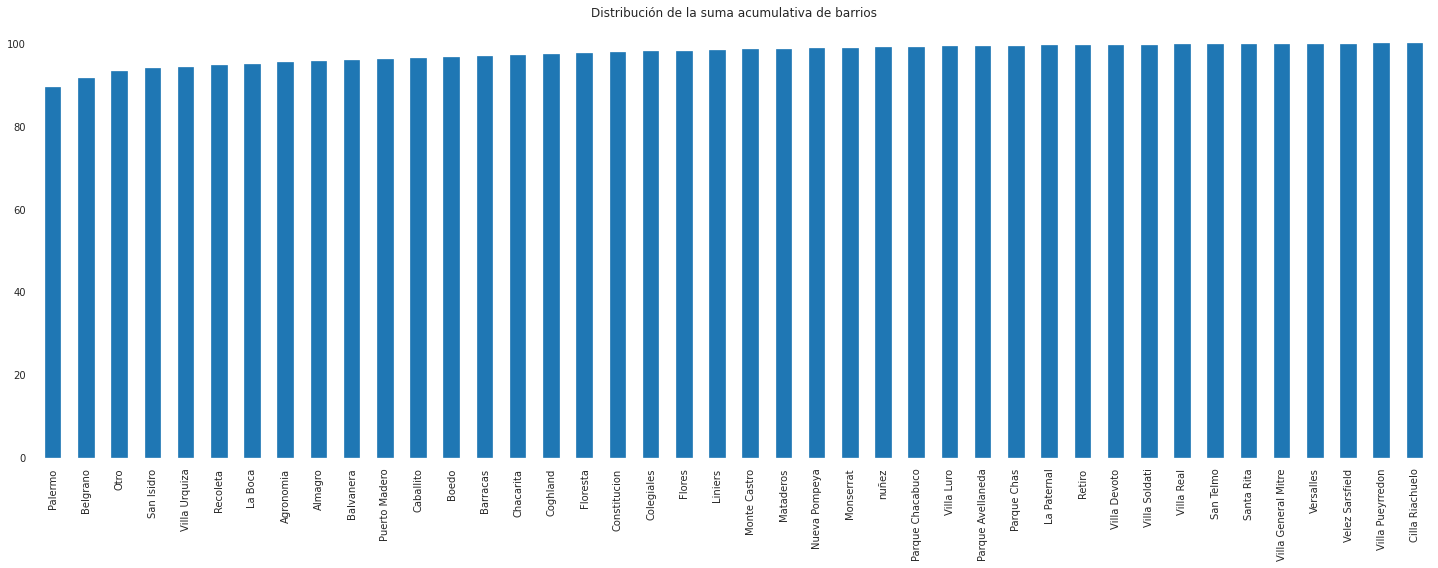

In [6]:
df['barrio'] = df['barrio'].replace(np.nan,'Otro')
barrios = df['barrio'].value_counts(normalize=True,dropna=False) * 100

barrios.cumsum().plot(
   kind='bar', title="Distribución de la suma acumulativa de barrios", figsize=(25, 8)
)
plt.plot()

De este gráfico, podemos observar que casi el 90% de los contribuyentes vive en el barrio de Palermo. Es decir, que se trata de una feature que además de tener una alta cardinaliad, tiene una baja varianza y a priori pareciera dificil poder establecer relaciones con otras variables

## ¿Qué sucede con los valores nulos en las features 'categoría de trabajo' y 'trabajo'? ¿Tiene alguna relación?

Como habiamos mencionado anteriormente, la cantidad de nulos en estas features es de un número parecido. Veamos si existe alguna relación que se pueda observar. En primer lugar veamos la feature categoria de trabajo

In [7]:
df['categoria_de_trabajo'].value_counts(dropna=False)

relacion_de_dependencia    22696
monotibutista               2541
empleado_municipal          2093
NaN                         1836
empleado_provincial         1298
responsable_inscripto       1116
empleadao_estatal            960
trabajo_voluntariado          14
sin_trabajo                    7
Name: categoria_de_trabajo, dtype: int64

Remplacemos el Nan por un 'No contesta' para poder entender mejor los datos, ya que estamos hablando de una variable categorica. Por otra parte,   se observa una distinción entre los distintos tipos de empleado público posible. Reasignemolos a una nueva categoria 'empleado_publico' y veamos la distribución de esta feature

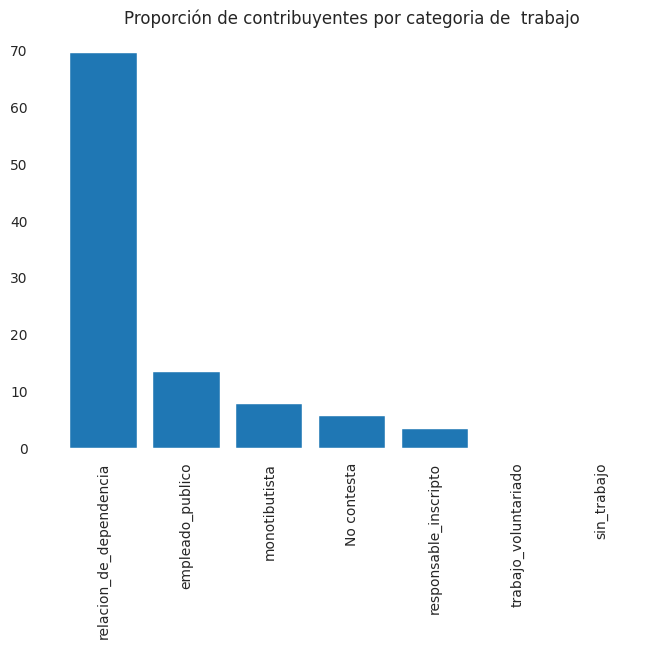

In [8]:
def generalizar_empleados_publicos(categoria):
    if categoria in ['empleado_municipal','empleado_provincial','empleadao_estatal']:
        return 'empleado_publico'
    return categoria
df['categoria_de_trabajo'] = df['categoria_de_trabajo'].replace(np.nan,'No contesta')
df['categoria_de_trabajo'] = df['categoria_de_trabajo'].apply(generalizar_empleados_publicos)
plt.figure(dpi = 100)
cantidad_por_trabajo = df['categoria_de_trabajo'].value_counts(normalize=True) * 100
plt.bar(cantidad_por_trabajo.index,cantidad_por_trabajo.values)
plt.title("Proporción de contribuyentes por categoria de  trabajo")
plt.xticks(rotation = 90)
plt.show()

Vemos que la gran mayoria de los contribuyentes se encuentra trabajando en el sector privado y en particular casi el 70% lo hace en relación de dependencia. Quizás en un futuro esta información nos sea útil, pero por el momento sigamos adelante. Veamos ahora la feature 'trabajo'

In [9]:
df['trabajo'].value_counts(dropna=False)

profesional_especializado    4140
reparador                    4099
directivo_gerente            4066
entretenimiento              3770
ventas                       3650
otros                        3295
inspector                    2002
NaN                          1843
transporte                   1597
limpiador                    1370
sector_primario               994
soporte_tecnico               928
seguridad                     649
servicio_domestico            149
ejercito                        9
Name: trabajo, dtype: int64

Podemos observar que no figura entre las posibles opciones estar desempleado, con lo cual quizas no estaba la opción a la hora de la construcción del dataset. Remplacemos los NaN por 'No contesta' y luego veremos si podemos obtener más información de quienes no contestaron

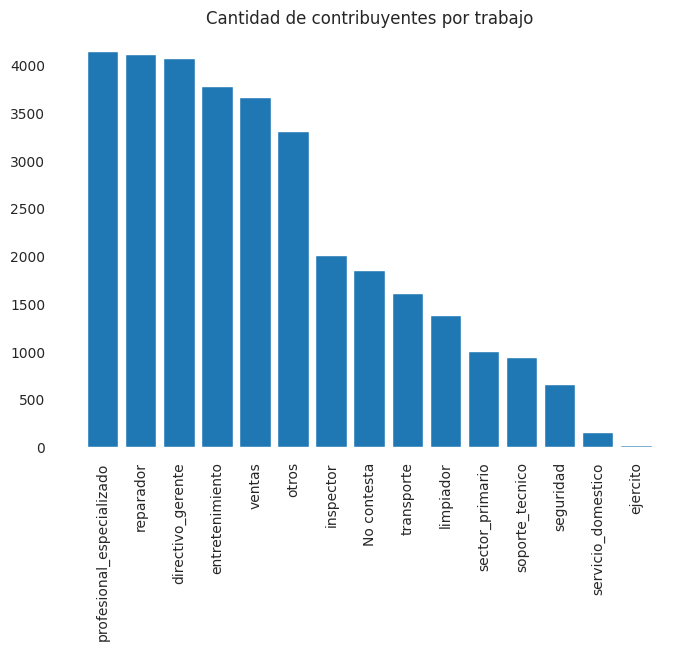

In [10]:
df['trabajo'] = df['trabajo'].replace(np.nan,'No contesta')
plt.figure(dpi = 100)
cantidad_por_trabajo = df['trabajo'].value_counts()
plt.bar(cantidad_por_trabajo.index,cantidad_por_trabajo.values)
plt.title("Cantidad de contribuyentes por trabajo")
plt.xticks(rotation = 90)
plt.show()

Vemos que hay cinco trabajos predominantes, lo cual por el momento no nos dice mucho

In [11]:
dataset_sin_contestar = df[df['categoria_de_trabajo'] == 'No contesta']
dataset_sin_contestar = dataset_sin_contestar[dataset_sin_contestar['trabajo'] == 'No contesta']
dataset_sin_contestar.shape

(1836, 13)

Se puede ver que trás filtrar el dataset quienes no contestan en la feature 'trabajo', tampoco lo hacen en la feature 'categoria_de_trabajo'. Ahora bien, ¿Se trata esto de un error en la recolección de los datos por parte de nuestra querida agencia? ¿Se tratará de desempleados que erronamente figuran en el dataset? ¿O son desempleados (quizás retirados) que conservan fuentes de ingreso que son gravables? 

## Aquellos de quienes desconocemos su trabajo,  ¿Operan en la bolsa?¿Qué edades tienen? ¿Presentan horas registradas trabajando?

Veamos primero como es la distribución de las edades

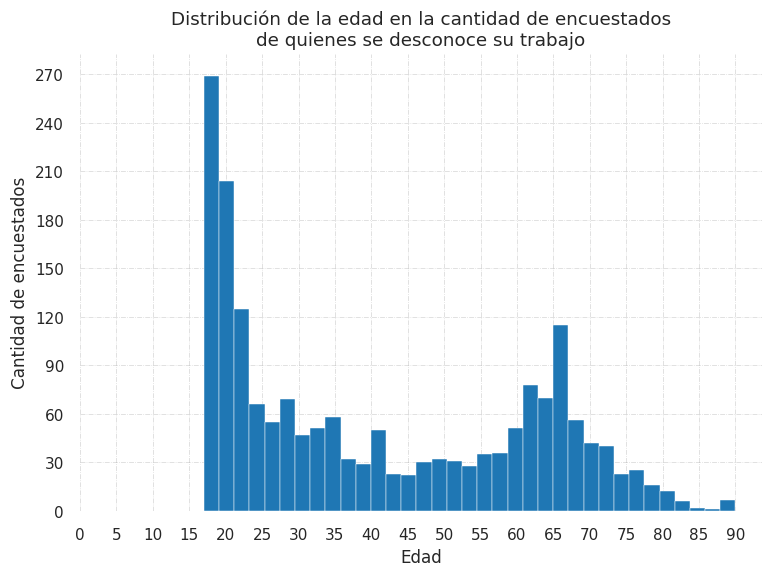

In [12]:
plt.figure(dpi=110)
bins_deseados = int(dataset_sin_contestar.edad.nunique()/2)
plt.hist(dataset_sin_contestar.edad, bins=bins_deseados, label="Edad")

plt.title("Distribución de la edad en la cantidad de encuestados\nde quienes se desconoce su trabajo")
plt.ylabel("Cantidad de encuestados")
plt.xlabel("Edad")
plt.xticks(np.arange(0,95, 5))
plt.yticks(np.arange(0,300, 30))
plt.grid(b = True, color ='grey', linestyle ='-.', linewidth = 0.5, alpha = 0.3)

plt.show()

No resulta llamativo una cierta concentración a partir de aproximadamente contribuyentes mayores a 60 años (pueden ser jubilados con bienes adicionales que sean gravables), pero ¿como se puede explicar la concentración que vemos en los sub 30? Investiguemos un poco más, quizás hemos identificado a genios del trading, que aún así no lograron evadir las garras de la FIUFIP

### Los menores a 30 años, ¿Tiene alta participación en la bolsa?

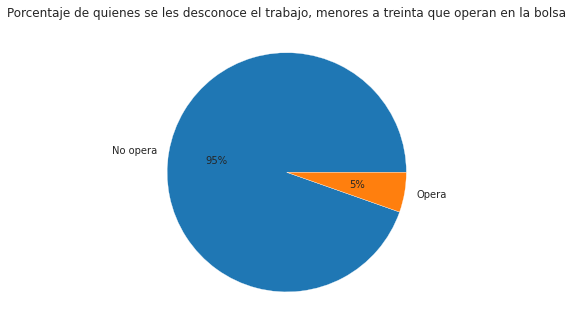

In [13]:
menores_a_treinta = dataset_sin_contestar[dataset_sin_contestar['edad'] <= 30]
porcentaje_que_opera = (menores_a_treinta['suma_declarada_bolsa_argentina'] != 0).value_counts(normalize=True)
porcentaje_que_opera.plot(kind='pie',autopct='%1.0f%%',labels = ['No opera','Opera'])
plt.title('Porcentaje de quienes se les desconoce el trabajo, menores a treinta que operan en la bolsa')
plt.ylabel('')
plt.show()


Bueno, pareciera que no se trata particularmente de genios de las finanzas, o al menos no de gente que tiene interés en comunicarlo. Veamos que sucede con las horas de trabajo registradas

### ¿Como es la distribución de horas trabajadas de estas personas?¿Y si es gente que esta desempleada y figura por error?

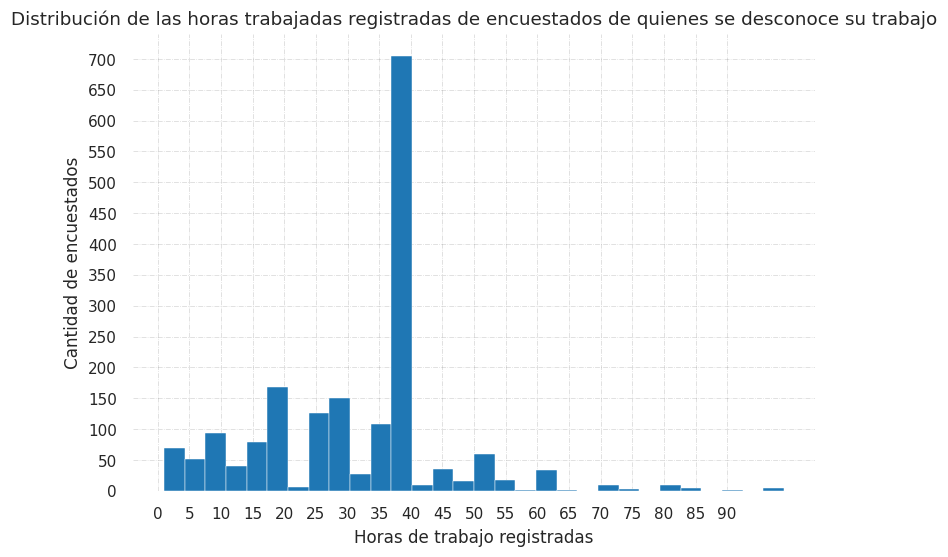

In [14]:
plt.figure(dpi=110)
bins_deseados = int(dataset_sin_contestar.horas_trabajo_registradas.nunique()/2)
plt.hist(dataset_sin_contestar.horas_trabajo_registradas, bins=bins_deseados, label="Edad")

plt.title("Distribución de las horas trabajadas registradas de encuestados de quienes se desconoce su trabajo")
plt.ylabel("Cantidad de encuestados")
plt.xlabel("Horas de trabajo registradas")
plt.xticks(np.arange(0,95, 5))
plt.yticks(np.arange(0,750, 50))
plt.grid(b = True, color ='grey', linestyle ='-.', linewidth = 0.5, alpha = 0.3)

plt.show()

Los datos resultan concluyentes. No parece tratarse de desempleados (a menos que acaben de perder el empleo y estos datos aún no se hayan actualizado) sino más bien gente de la que realmente no se tiene información. Habrá que mejorar la recolección de datos hecha por FIUFIP. 

# Se puede mentir con la edad en las redes, en persona, pero ... ¿Y a la FIUFIP?

Resulta de interés observar la distribución de edades de los contribuyentes. Reagrupemos en rangos y observemos

Antes de analizar, nos preguntamos por los missings, chequemos las variables numericas del a misma

In [15]:
(df.edad < 10).any()

False

Es decir, no hay ninguna edad incongruente.

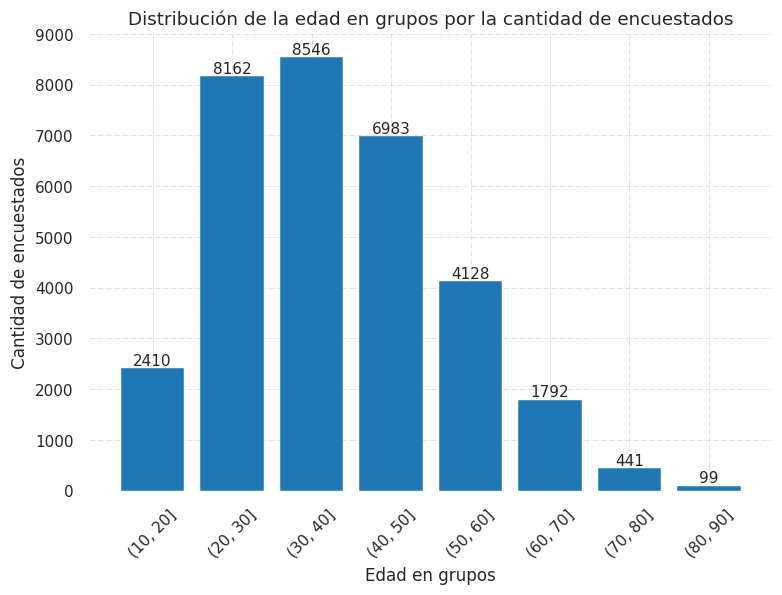

In [33]:
fig, ax = plt.subplots(dpi=110)
    
rango_edades =  np.arange(10,100,10)
cantidad_en_rango = pd.Series(pd.cut(df['edad'], bins = rango_edades).value_counts()).sort_index()

ploted = plt.bar(cantidad_en_rango.index.astype(str), cantidad_en_rango.values)

for rect in ploted:
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2., height,
            '%d' % int(height),
            ha='center', va='bottom')

plt.title("Distribución de la edad en grupos por la cantidad de encuestados")
plt.ylabel("Cantidad de encuestados")
plt.xlabel("Edad en grupos")
plt.grid(b = True, color ='grey', linestyle ='-.', linewidth = 0.5, alpha = 0.3)
plt.tick_params('x',labelrotation=45)
plt.yticks(np.arange(0,9500, 1000))
plt.show()

Justo como lo sospechabamos, hay una mayor cantidad de contribuyentes en el rango de los 20 años a los 50 años. Era esperable, se trata de los años donde la gran mayoria de las personas realiza su vida profesional. 

## Edad y horas trabajadas ¿Alguna relación con la categoria de trabajo?

La lógica indica que con el paso de los años, se tiende a trabajar menos. O al menos esperamos que sea asi. Veamos si hallamos una relación

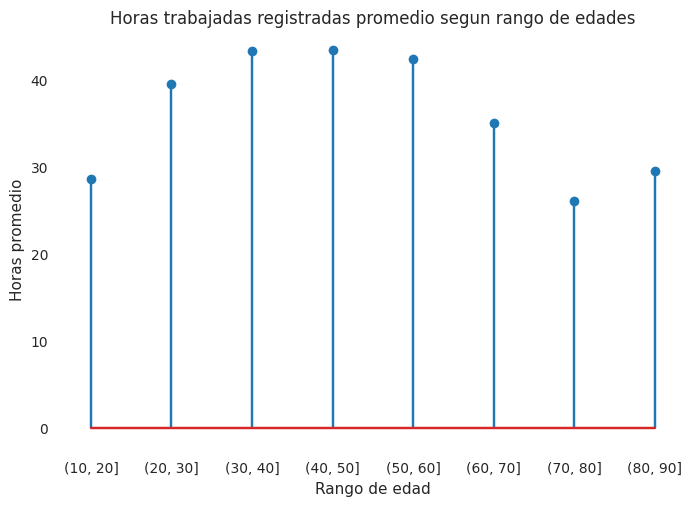

In [42]:
rango_edades =  np.arange(10,100,10)
pf = df
pf['rango'] = pd.Series(pd.cut(pf['edad'], bins = rango_edades))
pf = pf.groupby('rango').agg(list)
pf['horas_trabajadas_promedio'] = pf['horas_trabajo_registradas'].apply(np.mean)

plt.figure(dpi=100)
plt.stem(pf['horas_trabajadas_promedio'])
plt.title('Horas trabajadas registradas promedio segun rango de edades')
plt.xticks(np.arange(0,8,1),pf.index)
plt.xlabel('Rango de edad')
plt.ylabel('Horas promedio')

plt.show()


**CONCLUSION

## ¿Hay un rango de Edades que dé indicios de tener alto valor adquisitivo?

### ¿Como se distribuye el valor adquisitivo? *

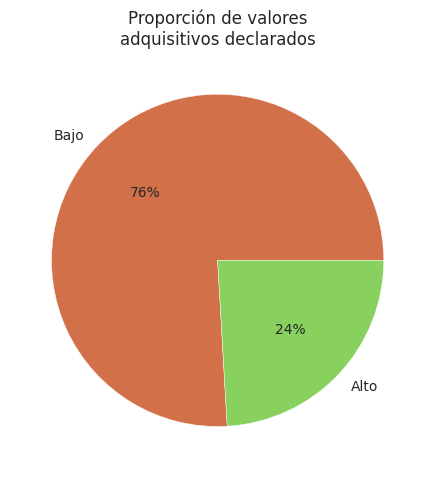

In [49]:
plt.figure(dpi=100)
valor_adquisitivo = df.tiene_alto_valor_adquisitivo.value_counts()
valor_adquisitivo.plot(kind='pie',labels= ['Bajo', 'Alto'], colors=['#D17049',"#89D15E"],autopct='%1.0f%%')
plt.title("Proporción de valores\nadquisitivos declarados")
plt.ylabel('')
plt.show()

**CONCLUSIÓN**

### Retomando... *

**Intro al grafico**

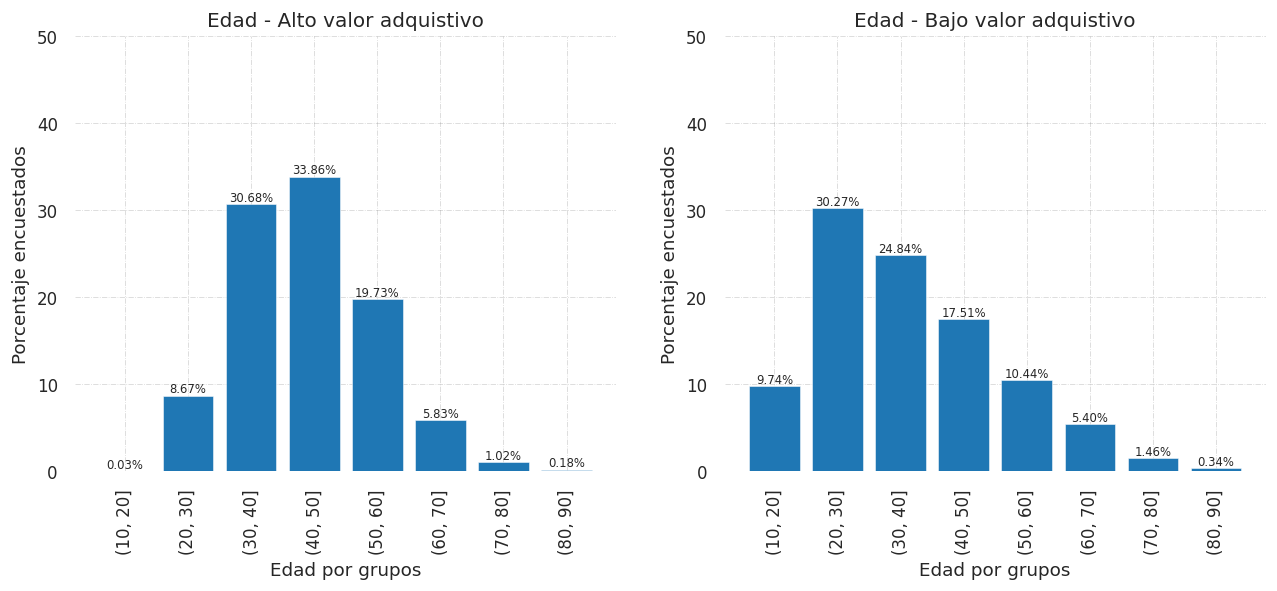

In [53]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=[6.4 * 2, 4.8], dpi=120)

df_alto_valor = df[df.tiene_alto_valor_adquisitivo == 1]
df_bajo_valor = df[df.tiene_alto_valor_adquisitivo == 0]

rango_edades =  np.arange(10,100,10)
cantidad_Altos_en_rango = pd.Series(pd.cut(df_alto_valor['edad'], bins = rango_edades).value_counts(normalize=True)*100).sort_index()
cantidad_Bajos_en_rango = pd.Series(pd.cut(df_bajo_valor['edad'], bins = rango_edades).value_counts(normalize=True)*100).sort_index()

ploted = axes[0].bar(cantidad_Altos_en_rango.index.astype(str), cantidad_Altos_en_rango.values)
ploted2 = axes[1].bar(cantidad_Bajos_en_rango.index.astype(str), cantidad_Bajos_en_rango.values)

for plot in [(ploted,axes[0]), (ploted2,axes[1])]:
    for rect in plot[0]:
        height = rect.get_height()
        plot[1].text(rect.get_x() + rect.get_width()/2., height, 
                '%0.2f%%' % float(height),
                ha='center', va='bottom', size=7)
        
    plot[1].grid(b = True, color ='grey', linestyle ='-.', linewidth = 0.5, alpha = 0.3)
    plot[1].tick_params('x',labelrotation=90)
    plot[1].set_ylabel("Porcentaje encuestados")
    plot[1].set_xlabel("Edad por grupos")
    plot[1].set_yticks(np.arange(0,60, 10))
    

axes[0].set_title("Edad - Alto valor adquistivo")
axes[1].set_title("Edad - Bajo valor adquistivo")

plt.show()


Algo que podemos identificcar de estas variables es que a medida que uno incrementa su edad, es decir, de 30 hasta los 50 años, empieza a tener un aumento de valor adquisitivo, y una bajada de bajo valor adquisitivo. 

Posterior a lo 50 años, tanto el valor adquisitivo alto y bajo empieza a decrecer por tener menor encuestados en esos rangos

Pero lo interesante, y que podemos concluir es que si pertences a un rango de edad [30, 50] uno es mas proppenso a tener mayor nivel adquisitivo

Aunque no parece algo muuy interesante si tenemos en cuenta que 

**CONCLUSION**

# ¿Como es la distribución en cuanto al género de los contribuyentes? *PENSAR TÍTULO

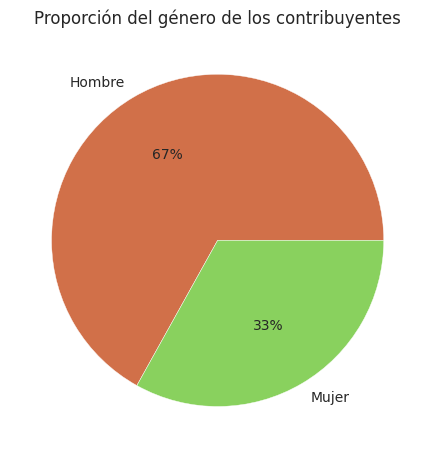

In [20]:
plt.figure(dpi=100)
cantidad_por_genero = df.genero.value_counts(normalize=True)
cantidad_por_genero.plot(kind='pie',labels= ['Hombre', 'Mujer'],colors=['#D17049',"#89D15E"],autopct='%1.0f%%')
plt.title('Proporción del género de los contribuyentes')
plt.ylabel('')
plt.show()



Se observa una mayor cantidad de hombres. Una posible explicación, podria ser que, aún en los tiempos que corren, las mujeres continuan realizando mayormente tareas domesticas no remuneradas que les impide trabajar. 

## ¿Hay igualdad de Genero en los valores adquisitivos declarados?

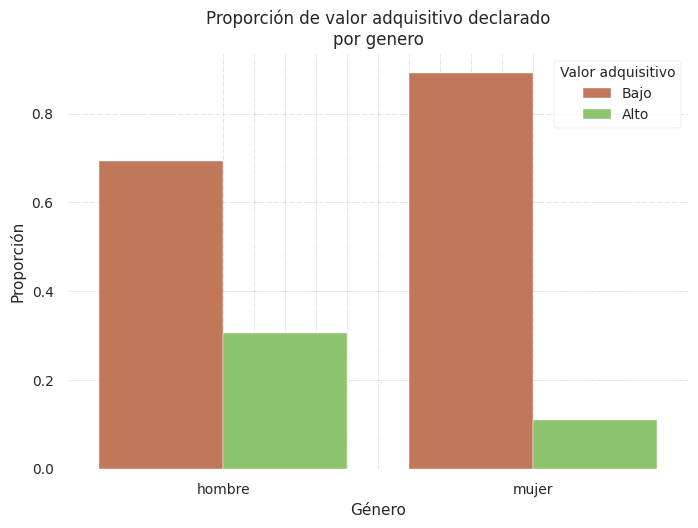

In [21]:
plt.figure(dpi = 100)
colors = ['#D17049', "#89D15E"]


bar_plot = sns.barplot(
    data=df.groupby("genero")
    .tiene_alto_valor_adquisitivo.value_counts(normalize=True)
    .rename("Proporción")
    .reset_index(),
    x='genero',
    y="Proporción",
    hue='tiene_alto_valor_adquisitivo',
    palette=colors,
)
bar_plot.set_xlabel("Género")
bar_plot.set_title("Proporción de valor adquisitivo declarado\npor genero")
bar_plot.set_xticks(np.arange(0,1.1, 0.1))
leg = bar_plot.get_legend()
leg.set_title("Valor adquisitivo")
labs = leg.texts
labs[0].set_text("Bajo")
labs[1].set_text("Alto")



plt.grid(b = True, color ='grey', linestyle ='-.', linewidth = 0.5, alpha = 0.3)


plt.show()

Como podemos observar, no es equitativa la declaración de alto valor adquisitivo. Osea que no solo hay más hombres, sino que estos tiene mas chances de calificar como de alto valor adquisitivo. ¿Qué es lo que puede llevar a esto?



##  ¿El género influye en las horas trabajadas?

Antes habiamos mencionado que una posibilidad de disparidad en cantidad de contribuyentes hombres y mujeres, era que aún estos tiempos era posible que más mujeres se ocupen solo de tareas domesticas. Pero ¿Y si esta tendencia se mantiene aún en aquellas mujeres que tiene un trabajo remunerado?

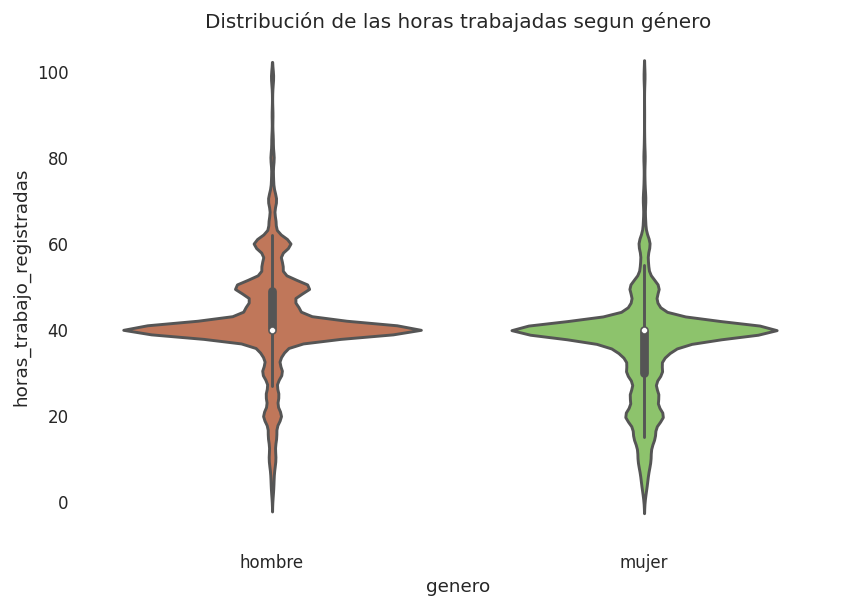

In [22]:
plt.figure(dpi=120)
plt.title("Distribución de las horas trabajadas segun género")
sns.violinplot(
    data=df,
    y='horas_trabajo_registradas',
    x='genero',
    palette=['#D17049', "#89D15E"],
)

plt.show()

Ver horas trabajadas de mujeres con hijos, casadas vs hombres con hijos y casados

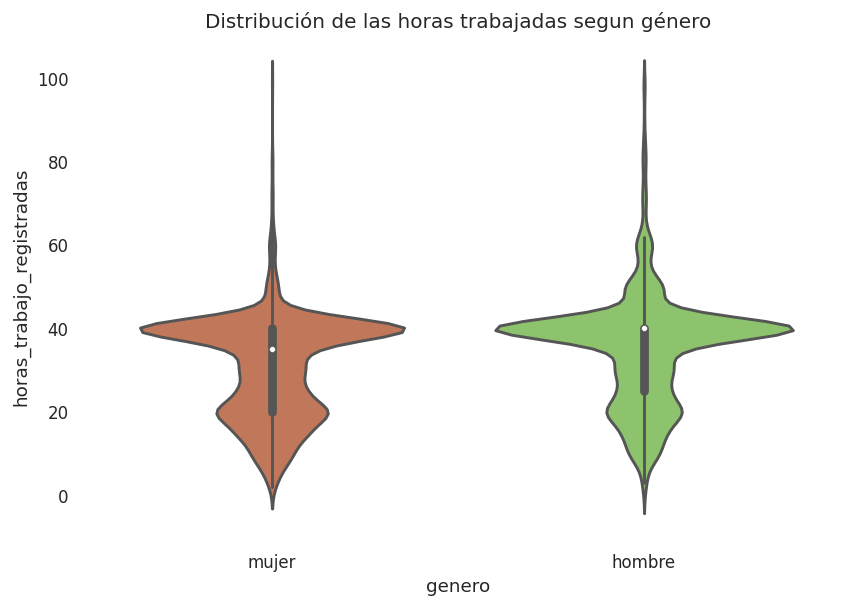

In [23]:
plt.figure(dpi=120)
plt.title("Distribución de las horas trabajadas segun género")
con_hijos = df[(df.rol_familiar_registrado == 'con_hijos')]
sns.violinplot(
    data=con_hijos,
    y='horas_trabajo_registradas',
    x='genero',
    palette=['#D17049', "#89D15E"],
)

plt.show()

# Con la democracia se come, se cura y ¿Se educa?


## ¿Los encuestados tienen elvada cantidad de años estudiados?


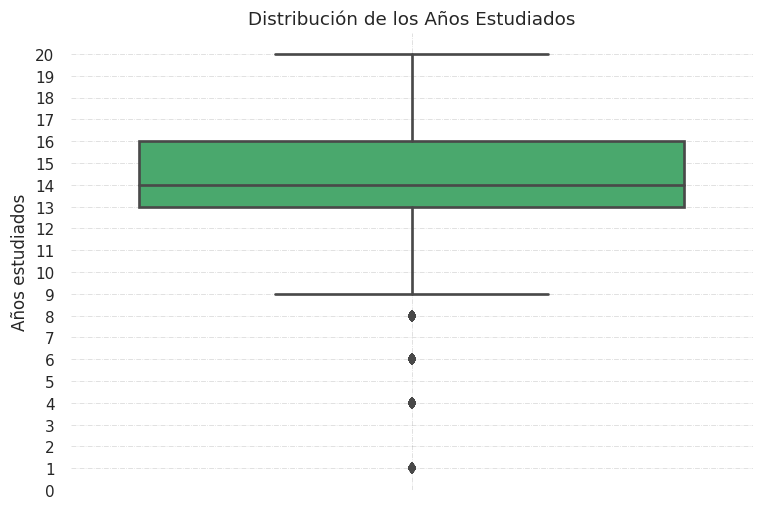

In [24]:
plt.figure(dpi=110)
plt.title("title")
sns.boxplot(
    y=df.anios_estudiados.values,
    color=(0.23, 0.72, 0.41),

)
plt.title("Distribución de los Años Estudiados")
plt.ylabel("Años estudiados")
plt.yticks(np.arange(0,21, 1))
plt.grid(b = True, color ='grey', linestyle ='-.', linewidth = 0.5, alpha = 0.3)

plt.show()


**Conclusion**

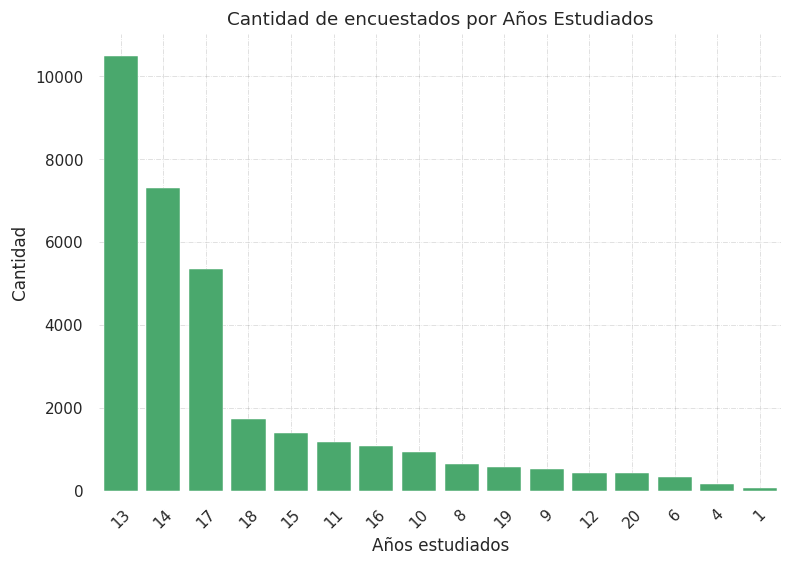

In [25]:
fig, ax = plt.subplots(dpi=110)

sns.countplot(
    x="anios_estudiados",
    data=df,
    order=df["anios_estudiados"].value_counts(normalize=True).index,
    color=(0.23, 0.72, 0.41),
    orient= "v",
)
plt.ylabel("Cantidad")
plt.xlabel("Años estudiados")
plt.title("Cantidad de encuestados por Años Estudiados")
plt.xticks(rotation=45)
plt.grid(b = True, color ='grey', linestyle ='-.', linewidth = 0.5, alpha = 0.3)
plt.show()



**Decidir cual mostramos

## ¿Como son los niveles de educacion alcanzados?

In [26]:
universitario = 'Universitario'
secundaria = 'Secundaria'
primaria = 'Primaria'
jardin = 'Jardin'

def agrupacion_educacion(educacion_alcanzada):
    return {'universidad_3_anio':universitario, '4_anio':secundaria, '2_anio':secundaria,  'universidad_4_anio':universitario, 
       '9_grado':primaria, '5_anio':secundaria,  'universidad_2_anio':universitario,  'universidad_1_anio':universitario, 
       '7-8_grado':primaria, 'universiada_6_anio':universitario,  'universiada_5_anio':universitario, 
       '5-6_grado':primaria, '1_anio':secundaria,  '1-4_grado':primaria, 'preescolar':jardin, '3_anio':secundaria}[educacion_alcanzada]


df['Educacion alcanzada generalizada'] = df.educacion_alcanzada.apply(agrupacion_educacion)

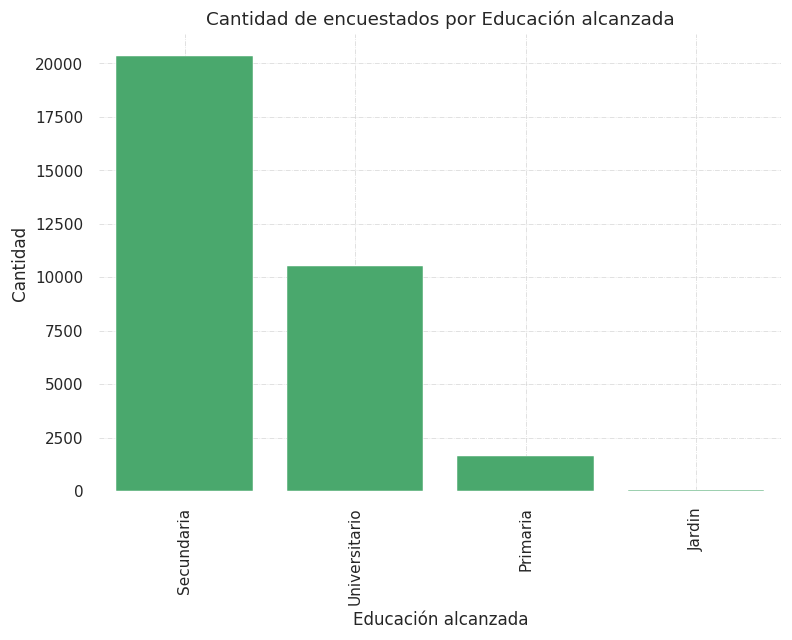

In [27]:
plt.figure(dpi=110)
sns.countplot(
    x="Educacion alcanzada generalizada",
    data=df,
    order=df['Educacion alcanzada generalizada'].value_counts(normalize=True).index,
    color=(0.23, 0.72, 0.41),
    orient= "v",
)
plt.ylabel("Cantidad")
plt.xlabel("Educación alcanzada")
plt.title("Cantidad de encuestados por Educación alcanzada")
plt.xticks(rotation=90)
plt.grid(b = True, color ='grey', linestyle ='-.', linewidth = 0.5, alpha = 0.3)
plt.show()

## Relacion entre años estudiados y lo lejos que se llega


**Mover esta parte en el grafico bar plot de arriba**

In [28]:
def agrupacion_educacion(categoria):
    if categoria in ['universidad_4_anio','universiada_5_anio','universiada_6_anio']:
        return 'Universitario - (3,6] grado'
    if categoria in ['universidad_1_anio','universidad_2_anio','universidad_3_anio']:
        return 'Universitario - [1,3] grado'
    if categoria in ['1_anio','2_anio','3_anio']:
        return 'Secundario - [1,3] grado'
    if categoria in ['4_anio','5_anio','6_anio']:
        return 'Secundario - (3,6] grado'
    if categoria in ['1-4_grado','5-6_grado']:
        return 'Primaria - [1,6] grado'
    if categoria in ['7-8_grado','9_grado']:
        return 'Primaria - (6,9] grado'
    if categoria in ['preescolar']:
        return 'Jardin'    
    return categoria


df['Educacion alcanzada generalizada distinta'] = df.educacion_alcanzada.apply(agrupacion_educacion)

In [29]:
lista_edu_alc_gen=df['Educacion alcanzada generalizada distinta'].value_counts()
lista_edu_alc_gen = lista_edu_alc_gen.sort_index( ascending=False)
lista_edu_alc_gen

Universitario - [1,3] grado     7804
Universitario - (3,6] grado     2712
Secundario - [1,3] grado        2541
Secundario - (3,6] grado       17792
Primaria - [1,6] grado           501
Primaria - (6,9] grado          1160
Jardin                            51
Name: Educacion alcanzada generalizada distinta, dtype: int64

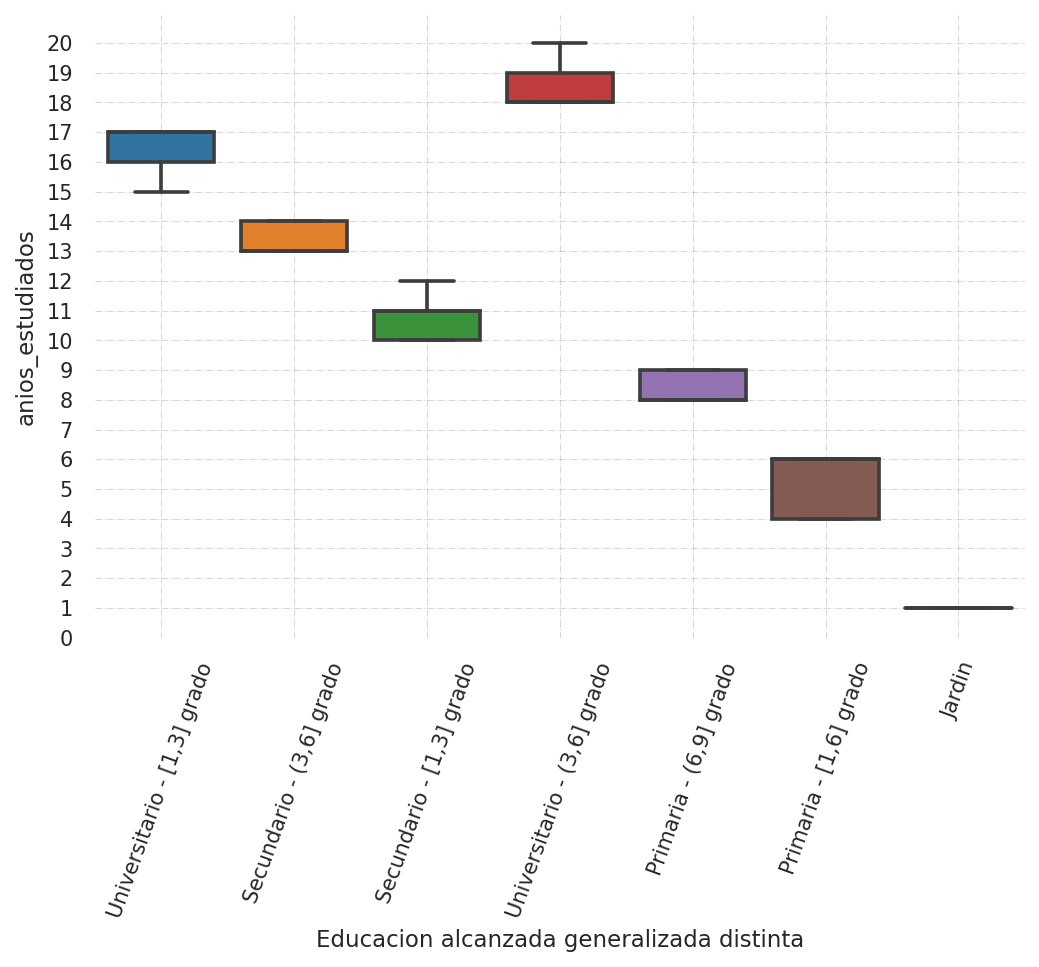

In [30]:
plt.figure(dpi=150)
#plt.title("Distribución del salario NETO según\nsi tiene gente a cargo en Argentina")
sns.boxplot(
    data=df,
    y=df.anios_estudiados,
    x='Educacion alcanzada generalizada distinta')
plt.xticks(rotation=70)
plt.yticks(np.arange(0,21, 1))
plt.grid(b = True, color ='grey', linestyle ='-.', linewidth = 0.5, alpha = 0.3)
plt.show()

## educacion y genero

## eduacion,años,valor_adquisitivo

In [31]:
def agrupacion_anios_estudiados(categoria):
    if categoria in np.arange(1,5).tolist():
        return '(0,4]'
    if categoria in np.arange(4,8).tolist():
        return '(4,7]'
    if categoria in np.arange(7,11).tolist():
        return '(7,10]'
    if categoria in np.arange(10,16).tolist():
        return '(10,15]'
    if categoria in np.arange(16,21).tolist():
        return '(15,20]'
    return categoria


df['Anios estudiados generalizada'] = df.anios_estudiados.apply(agrupacion_anios_estudiados)

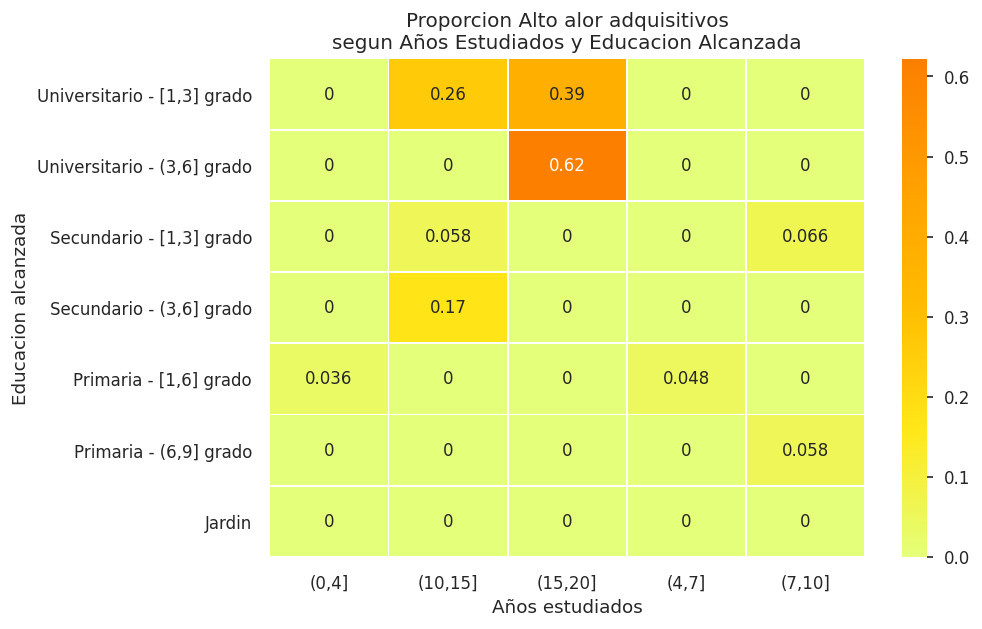

In [32]:
plt.figure(dpi=120)
pivoted = pd.pivot_table(
    data = df, 
    index ='Educacion alcanzada generalizada distinta', 
    values = 'tiene_alto_valor_adquisitivo', 
    columns = 'Anios estudiados generalizada',
)
pivoted.sort_index(ascending =  False, inplace = True)
pivoted = pivoted.replace(np.nan,0)
g = sns.heatmap(pivoted, annot=True, cmap="Wistia", linewidths=.5)
g.set_ylabel("Educacion alcanzada")
g.set_xlabel("Años estudiados")
g.set_title("Proporcion Alto alor adquisitivos\nsegun Años Estudiados y Educacion Alcanzada")

plt.show()

# Buscando al lobo de Wall Street Argentino

Cuando se tiene tiempo libre, cuando se dispone de capital o a veces por mera curiosidad, los trabajadores recurren a la bolsa a ver si se puede ganar algo más de dinero del que les da su actividad principal. Veamos que proporción de contribuyentes operan el bolsa Argentina. Vamos a tener en cuenta que es raro que quién opere en este tipo de activo financiero tenga un balance que le de justo cero, por lo que consideraremos que estos constribuyentes no operan en la bolsa

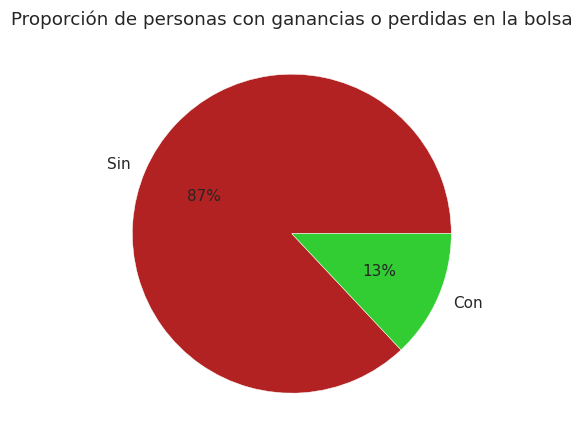

In [33]:
plt.figure(figsize=(6.4, 4.8), dpi=110)
plt.title('Proporción de personas con ganancias o perdidas en la bolsa')
plt.pie((df['suma_declarada_bolsa_argentina'] != 0).value_counts(), labels= ['Sin', 'Con'], colors=["firebrick",'limegreen'],autopct='%1.0f%%')
plt.ylabel('')
plt.show()

El gráfico es concluyente, el 13% de los contribuyentes del dataset opera en la bolsa

## ¿Hay algún estado marital que favorezca el interés por operar en la bolsa?

Por nuestra propia experiencia, muchos solteros/as que al no estar  acuden a la bolsa al no tener en donde invertir sus ahorros (y además poder ahorrar más). Veamos si esto es asi

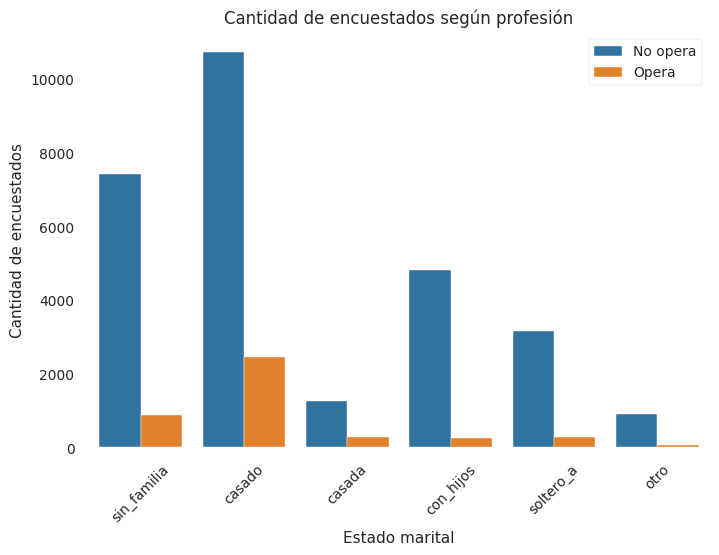

In [34]:
df['declaro_actividad_en_bolsa'] = df['suma_declarada_bolsa_argentina'] != 0
df['declaro_actividad_en_bolsa'].replace(False,0)

plt.figure(dpi = (100))
sns.countplot(
   data=df, x='rol_familiar_registrado', hue='declaro_actividad_en_bolsa'
)
plt.legend(labels=['No opera','Opera'])
plt.ylabel("Cantidad de encuestados")
plt.xlabel("Estado marital")
plt.title("Cantidad de encuestados según profesión")
plt.xticks(rotation=45)
plt.show()



plt.show()

**Conclusion**

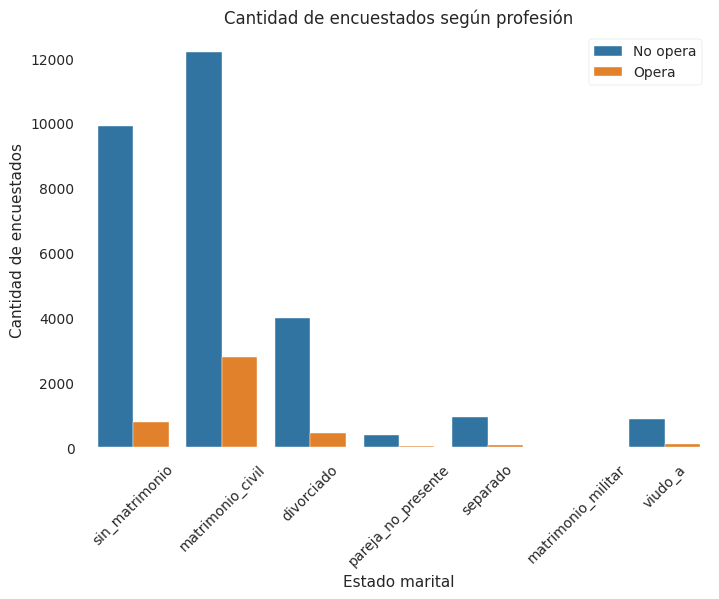

In [35]:
df['declaro_actividad_en_bolsa'] = df['suma_declarada_bolsa_argentina'] != 0
df['declaro_actividad_en_bolsa'].replace(False,0)

plt.figure(dpi = (100))
sns.countplot(
   data=df, x='estado_marital', hue='declaro_actividad_en_bolsa'
)
plt.legend(labels=['No opera','Opera'])
plt.ylabel("Cantidad de encuestados")
plt.xlabel("Estado marital")
plt.title("Cantidad de encuestados según profesión")
plt.xticks(rotation=45)
plt.show()



plt.show()

## Bolsa y poder adquisitivo

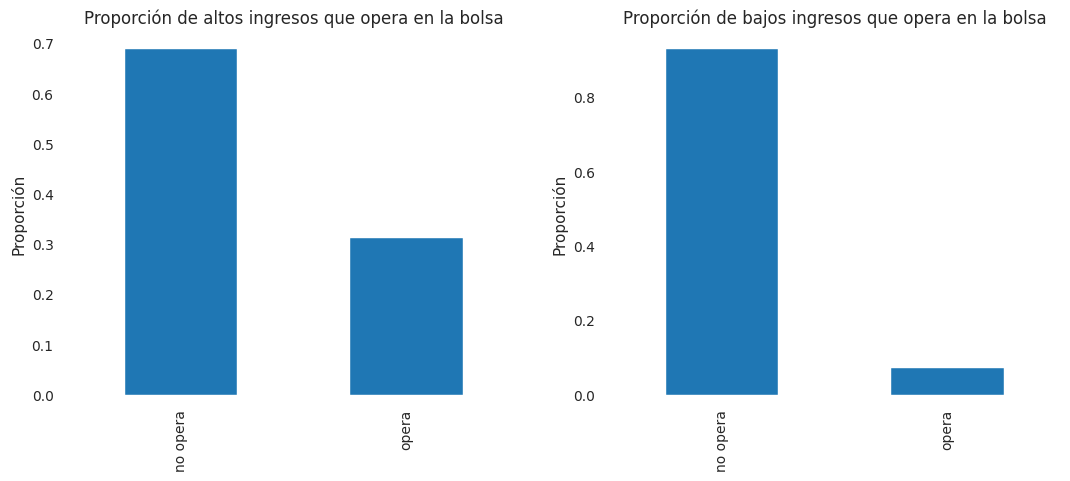

In [36]:
df['opera_en_bolsa'] = df['suma_declarada_bolsa_argentina'] != 0
df['gana_en_bolsa'] = df['suma_declarada_bolsa_argentina'] > 0
df['opera_en_bolsa'] = df['opera_en_bolsa'].replace({True : 'opera',False:'no opera'})
df['gana_en_bolsa'] = df['gana_en_bolsa'].replace({True : 'gana',False:'no_gana'})
dataset_altos_ingresos = df[df.tiene_alto_valor_adquisitivo != 0]
dataset_bajos_ingresos = df[df.tiene_alto_valor_adquisitivo == 0]



fig, axes = plt.subplots(nrows=1, ncols=2, figsize=[6.4 * 2, 4.8], dpi=100)


dataset_altos_ingresos.opera_en_bolsa.value_counts(normalize=True).plot(kind='bar', ax=axes[0])
axes[0].set_title("Proporción de altos ingresos que opera en la bolsa")
axes[0].set_ylabel("Proporción")

bar_plot = dataset_bajos_ingresos.opera_en_bolsa.value_counts(normalize=True).plot(kind='bar', ax=axes[1])
axes[1].set_title("Proporción de bajos ingresos que opera en la bolsa")
axes[1].set_ylabel("Proporción")



plt.show()


### A los que operan y es alto ¿ganan?

Distribucion de los que participan

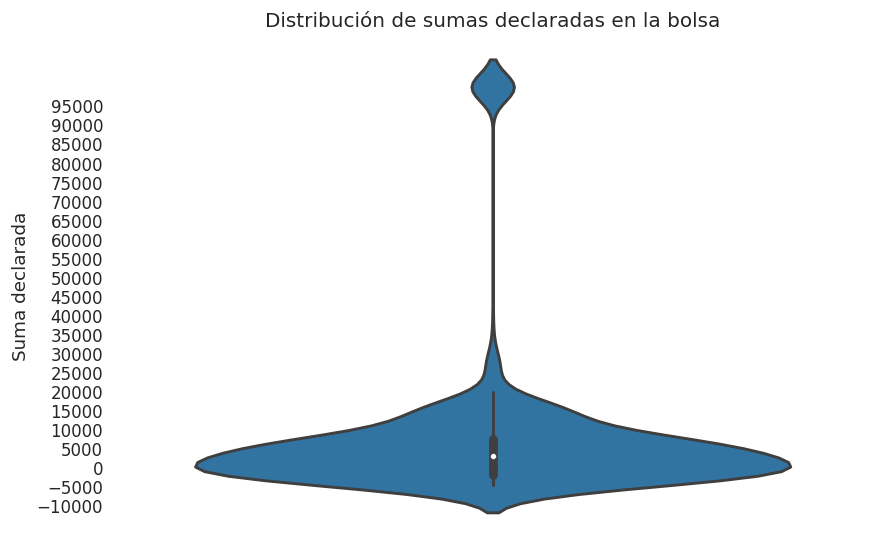

In [63]:
plt.figure(dpi=120)
los_que_operan = df[df.suma_declarada_bolsa_argentina != 0]
plt.title("Distribución de sumas declaradas en la bolsa")
sns.violinplot(
    data=los_que_operan,
    y='suma_declarada_bolsa_argentina',
)
plt.yticks(np.arange(-10000,100000,5000))
plt.ylabel("Suma declarada")
plt.show()

Distribucion de altos ingresos


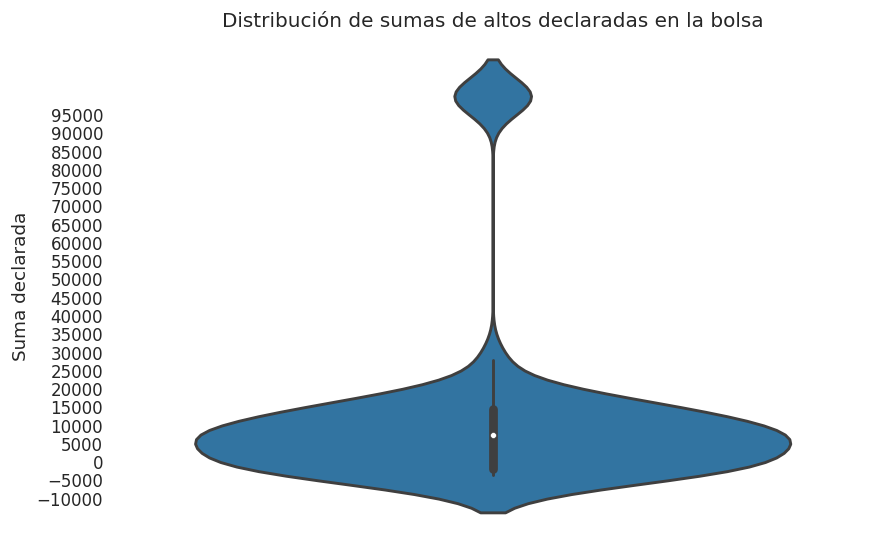

In [66]:
plt.figure(dpi=120)
los_que_operan_y_alto = df[(df.suma_declarada_bolsa_argentina != 0) & df.tiene_alto_valor_adquisitivo == 1]
plt.title("Distribución de sumas de altos declaradas en la bolsa")
sns.violinplot(
    data=los_que_operan_y_alto,
    y='suma_declarada_bolsa_argentina',
)
plt.yticks(np.arange(-10000,100000,5000))
plt.ylabel("Suma declarada")
plt.show()

Distribucion de bajos ingresos


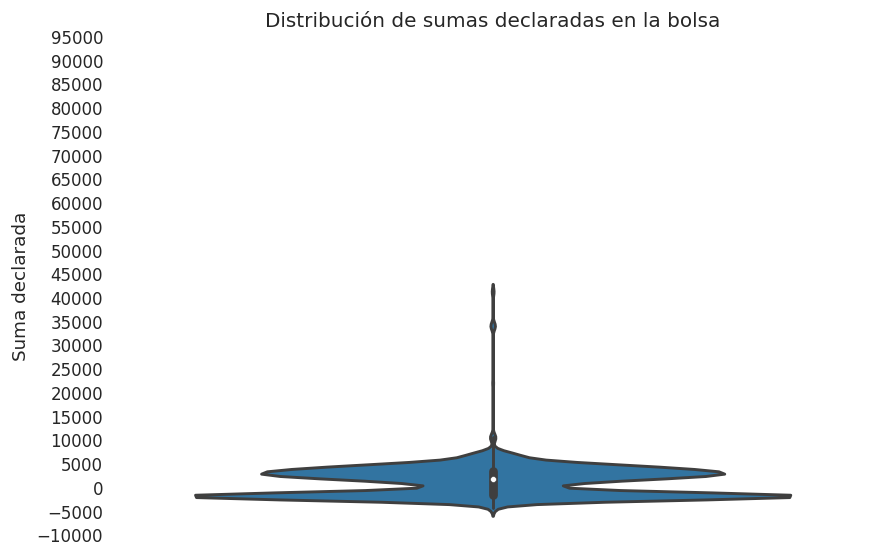

In [65]:
plt.figure(dpi=120)
los_que_operan_y_bajo = df[(df.suma_declarada_bolsa_argentina != 0) & (df.tiene_alto_valor_adquisitivo == 0)]
plt.title("Distribución de sumas declaradas en la bolsa")
sns.violinplot(
    data=los_que_operan_y_bajo,
    y='suma_declarada_bolsa_argentina',
)
plt.yticks(np.arange(-10000,100000,5000))
plt.ylabel("Suma declarada")
plt.show()

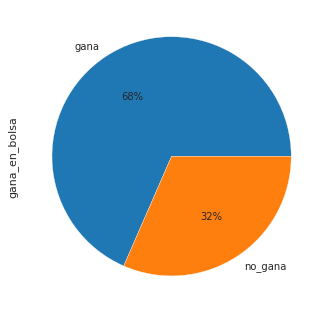

In [38]:
dataset_altos_que_operan = dataset_altos_ingresos[dataset_altos_ingresos.opera_en_bolsa == 'opera']
dataset_altos_que_operan.gana_en_bolsa.value_counts(normalize=True).plot(kind='pie',autopct='%1.0f%%')
plt.show()


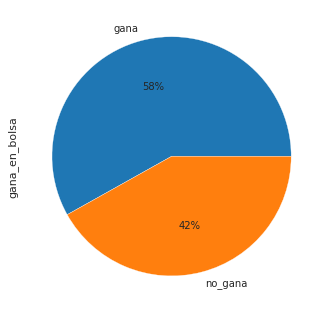

In [39]:
dataset_bajos_que_operan = dataset_bajos_ingresos[dataset_bajos_ingresos.opera_en_bolsa == 'opera']
dataset_bajos_que_operan.gana_en_bolsa.value_counts(normalize=True).plot(kind='pie',autopct='%1.0f%%')
plt.show()

# Indaguemos un poco más sobre los ricos

## valor adquisitivo y trabajo

## valor adquisitivo y religion

## valor adquisitivo y estado marital 

# BASELINE